In [2]:
import json
import pandas as pd
import numpy as np
import joblib 
import re
import matplotlib.pyplot as plt
import io, os
import shap
import datetime as dt
import pickle as pkl
import random
import unicodedata
from os import path
from tqdm import tqdm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from transformers import AutoTokenizer, AutoModel

from typing import List, Tuple, Dict, Any

import torch

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows',200)
%matplotlib inline

In [3]:
def build_dataset() -> Tuple[List[Dict[str, Any]], List[str], List[Dict[str, Any]], List[str]]:
    """
    Builds the dataset by splitting into training and test sets.
    
    Returns:
        Tuple containing training data, training labels, test data, and test labels.
    """
    with open("MLA_100k.jsonlines", "r") as file:
        data = [json.loads(x) for x in file]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        x.pop("condition", None)
    return X_train, y_train, X_test, y_test

def normalize_data(X: List[Dict[str, Any]], y: List[str]) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Normalizes the data and converts labels to integers.
    
    Args:
        X: List of dictionaries representing the data.
        y: List of labels.
    
    Returns:
        Tuple containing normalized data as a DataFrame and labels as a Series.
    """
    y = pd.Series(y).replace({'new': 1, 'used': 0}).astype(int)
    print('Normalizing JSON...')
    X = pd.json_normalize(X)
    return X, y

def formatear_utf_8(s: str) -> str:
    """
    Removes special characters and encodes text to UTF-8.
    
    Args:
        s: Input string.
    
    Returns:
        Formatted string.
    """
    s = s.lower()
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
    s = re.sub(r'([\'\"\.\(\)\!\?\-\\\/\,])', r' \1 ', s)
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    s = s.replace('&', ' y ')
    s = s.replace('@', ' arroba ')
    s = s.replace('0', ' cero ')
    s = s.replace('1', ' uno ')
    s = s.replace('2', ' dos ')
    s = s.replace('3', ' tres ')
    s = s.replace('4', ' cuatro ')
    s = s.replace('5', ' cinco ')
    s = s.replace('6', ' seis ')
    s = s.replace('7', ' siete ')
    s = s.replace('8', ' ocho ')
    s = s.replace('9', ' nueve ')
    s = re.sub('[^A-Za-z0-9]+', ' ', unicodedata.normalize('NFD', s).encode('ascii', 'ignore').decode("utf-8"))
    return str(s)

def warranty(df_flatted: pd.DataFrame) -> pd.DataFrame:
    """
    Processes the warranty feature in the dataset.
    
    Args:
        df_flatted: DataFrame containing the dataset with a 'warranty' column.
    
    Returns:
        DataFrame with the processed 'warranty' column.
    """
    print('Processing warranty...')
    
    known_warranties = ['sin_datos', 'si', 'sin garantia']
    
    df_flatted['warranty'] = df_flatted['warranty'].fillna('sin_datos').str.lower().apply(formatear_utf_8)
    
    mapping_rules = [
        ('fabr', 'si'),
        ('meses', 'si'),
        ('reputacion', 'sin garantia'),
        ('con garantia', 'si'),
        ('garantia total', 'si'),
        ('ano', 'si')
    ]
    
    def map_warranty(warranty: str) -> str:
        for substring, replacement in mapping_rules:
            if substring in warranty:
                return replacement
        return warranty
    
    df_flatted['warranty'] = df_flatted['warranty'].apply(map_warranty)
    df_flatted['warranty'] = df_flatted['warranty'].apply(lambda x: x if x in known_warranties else 'otros')
    
    return df_flatted

def tags(df_flatted: pd.DataFrame) -> pd.DataFrame:
    """
    Processes the tags feature in the dataset.
    
    Args:
        df_flatted: DataFrame containing the dataset with a 'tags' column.
    
    Returns:
        DataFrame with the processed 'tags' column.
    """
    print('Processing tags...')
    known_tags = ['dragged_bids_and_visits', 'no_info']
    
    tags_df = df_flatted['tags'].explode()
    tags_df.fillna('no_info', inplace=True)
    tags_df = tags_df.apply(lambda x: x if x in known_tags else 'otros')
    df_flatted['tags'] = tags_df[~tags_df.index.duplicated(keep='first')]
    
    return df_flatted

def process_title(df: pd.DataFrame) -> pd.DataFrame:
    """
    Processes the title feature by formatting to UTF-8 and handling missing values.
    
    Args:
        df: DataFrame containing the dataset with a 'title' column.
    
    Returns:
        DataFrame with the processed 'title' column.
    """
    print('Formatting features to UTF-8...')
    df_nlp = df.copy()
    shape_init = len(df_nlp)
    
    df_nlp['title'] = df_nlp['title'].fillna('nan')
    df_nlp['title'] = df_nlp['title'].str.lower()
    df_nlp['title'] = df_nlp['title'].apply(formatear_utf_8)
    
    if shape_init - len(df_nlp) != 0:
        print('Records were lost, check the data.')
    
    return df_nlp

def listings_type_id(df_flatted: pd.DataFrame) -> pd.DataFrame:
    """
    Processes the listing type ID feature by categorizing and encoding.
    
    Args:
        df_flatted: DataFrame containing the dataset with a 'listing_type_id' column.
    
    Returns:
        DataFrame with the processed 'listing_type_id' column.
    """
    print('Processing listings...')
    
    df_flatted['listing_type_id'] = df_flatted['listing_type_id'].apply(lambda x: 'gold' if 'gold' in x else x).copy()
    df_flatted['listing_type_id'].replace({
        'free': 1,
        'bronze': 2,
        'silver': 3,
        'gold': 4
    }, inplace=True)
    
    return df_flatted



# Cargar la data desde json

In [4]:
print("Loading dataset...")
X_train, y_train, X_test, y_test = build_dataset()

Loading dataset...


# Preprocessing

In [5]:
X_train, y_train = normalize_data(X_train, y_train)
X_test, y_test = normalize_data(X_test, y_test) 

X_train['condition'] = X_train['condition'].replace({'new':1, 'used':0})
X_train = process_title(X_train)
X_train = tags(X_train)
X_train = warranty(X_train)
X_train = listings_type_id(X_train)

Normalizing JSON...
Normalizing JSON...
Formatting features to UTF-8...
Processing tags...
Processing warranty...
Processing listings...


## Usamos Featurewiz para reducir la cantidad de features

In [6]:
from featurewiz import featurewiz

Imported lazytransform v1.16. 

Imported featurewiz 0.5.7. Use the following syntax:
    >>> wiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True,
        		category_encoders="auto", auto_encoders='VAE', ae_options={},
        		add_missing=False, imbalanced=False, verbose=0)
    >>> X_train_selected, y_train = wiz.fit_transform(X_train, y_train)
    >>> X_test_selected = wiz.transform(X_test)
    >>> selected_features = wiz.features
    


In [11]:
data_combined = X_train.copy()
data_combined['condition'] = y_train.copy()

In [12]:
features, train_data = featurewiz(
    dataname=data_combined, target='condition', corr_limit=0.7, verbose=1, sep=',', header=0, 
    test_data='', feature_engg='', category_encoders='', 
    dask_xgboost_flag=False, nrows=None
)

print("Selected Features:", features)
print("Transformed Training Data:", train_data.head())

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
    Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
    Single_Label Binary_Classification problem 
    Loaded train data. Shape = (90000, 9)
    Single_Label Binary_Classification problem 
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
    Single_Label Binary_Classification problem 
    loading a random sample of 10000 rows into pandas for EDA
###########################################

In [13]:
print("Selected Features:", features)
train_data.head()

Selected Features: ['initial_quantity', 'listing_type_id', 'warranty', 'buying_mode', 'tags']


,initial_quantity,listing_type_id,warranty,buying_mode,tags,condition
0,1,2,0,1,0,1
1,1,3,2,1,1,0
2,1,2,0,1,0,0
3,1,3,0,1,1,1
4,1,2,2,1,0,0


## Selecting useful features

In [10]:
useful_cols = ['warranty', 'listing_type_id', 'price', 'buying_mode','category_id','title','condition','tags','initial_quantity']
X_train = X_train[useful_cols]

In [7]:
from ydata_profiling import ProfileReport
profile = ProfileReport(X_train, title="Profiling Report")
profile.to_file("problem_report.html")

## Usando embeddings para title

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

In [ ]:
def get_embeddings(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings

In [ ]:
if torch.cuda.is_available():
    print("GPU is available and being used by PyTorch.")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"Current GPU device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("No GPU available, PyTorch is using the CPU.")

In [ ]:
embeddings = []
for title in tqdm(X_train['title']):
    embedding = get_embeddings(title, tokenizer, model)
    embeddings.append(embedding.squeeze().numpy())
embeddings_df = pd.DataFrame(embeddings)
df_with_embeddings = pd.concat([X_train, embeddings_df], axis=1)

In [ ]:
df_with_embeddings.to_csv('dataset_embeddings.csv')

In [ ]:
df_with_embeddings

## Probamos random forest simple

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [9]:
X = X_train.copy().drop('condition', axis=1)
y = X_train['condition']

In [10]:
def encode_run_rf(X, y):
    
    X.drop(['category_id', 'title'], axis=1, inplace=True)
    
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    
    encoder = OneHotEncoder(sparse=False, drop='first')
    X_encoded = encoder.fit_transform(X[categorical_features])
    
    X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_features))
    
    X_encoded_df.columns = X_encoded_df.columns.astype(str)
    
    X = X.drop(categorical_features, axis=1)
    X = pd.concat([X, X_encoded_df], axis=1)   
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = rf.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    return rf, X_test

In [11]:
rf_trained, X_test_rf = encode_run_rf(X,y)

C:\Users\esteban\mambaforge\envs\pycaret\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy: 0.82


In [12]:
X_test_rf

,listing_type_id,price,initial_quantity,warranty_si,warranty_sin garantia,buying_mode_buy_it_now,buying_mode_classified,tags_no_info,tags_otros
89610,2,200.00,1,0.0,1.0,1.0,0.0,0.0,0.0
12456,3,299.00,2,0.0,0.0,1.0,0.0,0.0,1.0
53403,1,24.99,1,0.0,0.0,1.0,0.0,0.0,0.0
62905,4,499.99,2,1.0,0.0,1.0,0.0,0.0,0.0
66339,2,200.00,1,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
48954,2,40.00,1,0.0,0.0,1.0,0.0,0.0,0.0
38743,2,120.00,1,0.0,0.0,1.0,0.0,0.0,0.0
57097,3,125000.00,1,0.0,0.0,0.0,1.0,1.0,0.0
54782,2,40.00,1,0.0,0.0,1.0,0.0,0.0,0.0


In [13]:
X_test_shap = X_test_rf.sample(2000)

In [14]:
X_test_rf

,listing_type_id,price,initial_quantity,warranty_si,warranty_sin garantia,buying_mode_buy_it_now,buying_mode_classified,tags_no_info,tags_otros
89610,2,200.00,1,0.0,1.0,1.0,0.0,0.0,0.0
12456,3,299.00,2,0.0,0.0,1.0,0.0,0.0,1.0
53403,1,24.99,1,0.0,0.0,1.0,0.0,0.0,0.0
62905,4,499.99,2,1.0,0.0,1.0,0.0,0.0,0.0
66339,2,200.00,1,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
48954,2,40.00,1,0.0,0.0,1.0,0.0,0.0,0.0
38743,2,120.00,1,0.0,0.0,1.0,0.0,0.0,0.0
57097,3,125000.00,1,0.0,0.0,0.0,1.0,1.0,0.0
54782,2,40.00,1,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
explainer = shap.TreeExplainer(rf_trained)
shap_values = explainer.shap_values(X_test_shap)

In [ ]:
shap.summary_plot(shap_values, X_test_shap, plot_type="dot")

In [ ]:
plt.show()

## Usando PyCaret

In [ ]:
import mlflow
mlflow.set_tracking_uri('http://127.0.0.1:5000')

In [16]:
import pandas as pd
from pycaret.datasets import get_data
from pycaret.classification import setup, compare_models, get_config

In [17]:
from pycaret.classification import *
clf1 = setup(X_train, target = 'condition', session_id=123, log_experiment=True, experiment_name='pycaret_primer_run')

,Description,Value
0,Session id,123
1,Target,condition
2,Target type,Binary
3,Original data shape,"(90000, 9)"
4,Transformed data shape,"(90000, 15)"
5,Transformed train set shape,"(62999, 15)"
6,Transformed test set shape,"(27001, 15)"
7,Numeric features,3
8,Categorical features,5
9,Preprocess,True


In [18]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7817,0.8256,0.8938,0.7487,0.8148,0.5541,0.5671,0.4900
gbc,Gradient Boosting Classifier,0.7070,0.7924,0.8515,0.6818,0.7554,0.3993,0.4228,0.5850
rf,Random Forest Classifier,0.6911,0.7621,0.8672,0.6626,0.7509,0.3629,0.3874,0.3620
xgboost,Extreme Gradient Boosting,0.6679,0.7253,0.7695,0.6651,0.7129,0.3237,0.3300,0.5880
lightgbm,Light Gradient Boosting Machine,0.6638,0.7097,0.8004,0.6518,0.7178,0.3115,0.3242,0.2350
ada,Ada Boost Classifier,0.6552,0.7071,0.7324,0.6614,0.6932,0.3010,0.3063,0.3600
et,Extra Trees Classifier,0.6459,0.6685,0.7412,0.6475,0.6899,0.2802,0.2866,0.3080
dt,Decision Tree Classifier,0.6449,0.6421,0.6997,0.6576,0.6715,0.2836,0.2908,0.1720
ridge,Ridge Classifier,0.5645,0.0000,0.9987,0.5524,0.7114,0.0631,0.1719,0.1650
lda,Linear Discriminant Analysis,0.5453,0.8753,0.9988,0.5417,0.7024,0.0188,0.0850,0.1930


In [27]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7256,0.7892,0.8540,0.7006,0.7697,0.4382,0.4515
1,0.6883,0.7286,0.8570,0.6621,0.7470,0.3579,0.3785
2,0.7124,0.8311,0.9246,0.6677,0.7755,0.4031,0.4463
3,0.6619,0.7190,0.8588,0.6376,0.7319,0.3005,0.3256
4,0.6660,0.7343,0.8490,0.6434,0.7320,0.3106,0.3321
5,0.6721,0.7530,0.8032,0.6601,0.7247,0.3287,0.3385
6,0.6629,0.7040,0.8505,0.6402,0.7305,0.3035,0.3259
7,0.6994,0.7721,0.8650,0.6708,0.7556,0.3809,0.4021
8,0.7240,0.7938,0.9123,0.6817,0.7803,0.4293,0.4632


In [29]:
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

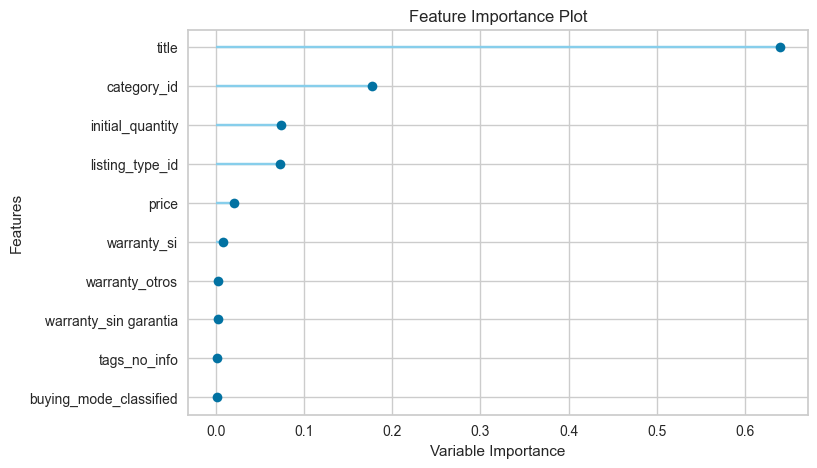

In [32]:
plot_model(rf, plot='feature')
